# Access CRDB through REST interface

A [REST](https://en.wikipedia.org/wiki/Representational_state_transfer) interface is available at the following URL: http://lpsc.in2p3.fr/crdb/rest.php to query the database.

Click on the tab "REST interface" to see the list of parameters. Minimal required are the parameters `num` and `energy_type`. There are several optional parameters, see the website for details.

A REST query to the database is asking for data. The parameters specify what data to pull and in which format. The query URL has this format:

`url?par1=value1&par2=value2&...&parN=valueN`

where `url` is `http://lpsc.in2p3.fr/crdb/rest.php`, `par1` to `parN` are parameter names and `value1` to `valueN` are parameter values. Name and value pairs are connected by `=`, and individual pairs are linked by `&`.

The `num` parameter is the element, isotope, or particle, whose flux is requested. Valid values are `H`, `He`, `e+` written as `e%2B`, `3H`, and so on. A flux ratio can be requested by also providing the optional `den` parameter, then `num` stands for numerator and `den` for denominator. The other required parameter is `energy_type`. It is used to request the energy unit. Valid values are `EKN`, `EK`, `R`, `ETOT`. See the website for details.

## Using curl

To start queries from a terminal we recommend the program `curl`, which is available for Linux and MacOSX (e.g. via homebrew).

The following command downloads all available boron-to-carbon flux ratios as a function of kinetic energy per nucleon, and save the output in a file called `db.txt`.

In [1]:
!curl -L 'http://lpsc.in2p3.fr/crdb/rest.php?num=B&den=C&energy_type=EKN' > db.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 97282    0 97282    0     0   156k      0 --:--:-- --:--:-- --:--:--  156k


In [2]:
# first 25 lines of what we downloaded
!head -25 db.txt

# Data export from CRDB [http://lpsc.in2p3.fr/crdb]
# Please cite Maurin, Melot, Taillet, A&A 569, A32 (2014) [https://ui.adsabs.harvard.edu/abs/2014A%26A...569A..32M]
# Date: 2020/06/02-11:41:54
# Format: USINE code
#   Col.1  -  QUANTITY NAME (case insensitive)
#   Col.2  -  SUB-EXP NAME (case insensitive, no space)
#   Col.3  -  EAXIS TYPE: EKN, EK, R, or ETOT
#   Col.4  -  <E>: mean value bin [GeV/n, GeV, GV, or GeV]
#   Col.5  -  EBIN_LOW
#   Col.6  -  EBIN_HIGH
#   Col.7  -  QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio
#   Col.8  -  ERR_STAT-
#   Col.9  -  ERR_STAT+
#   Col.10 -  ERR_SYST-
#   Col.11 -  ERR_SYST+
#   Col.12 -  ADS URL FOR PAPER REF (no space)
#   Col.13 -  phi [MV]
#   Col.14 -  DISTANCE EXP IN SOLAR SYSTEM [AU]
#   Col.15 -  DATIMES: format = yyyy/mm/dd-hhmmss:yyyy/mm/dd-hhmmss;...
#   Col.16 -  IS UPPER LIMIT: format = 0 or 1
#
B/C                                  ACE-CRIS(1997/08-1998/04)                     EKN        7.200000e-2     7.200000e

## Using Python

Using a Python script is convenient if the queried data is directly going to processed further, or if multiple queries are going to be made.

The module [crdb.py](./crdb.py) in this repository contains a complete solution to query the database and convert the output to a `numpy` record array. It requires `numpy` to run, which you can install `pip install numpy`. The code was tested on Python3.7, but should work with older versions of Python3.

In [3]:
import crdb
help(crdb.query)

Help on function query in module crdb:

query(num, den=None, energy_type='R', url=None, **kwargs)
    Queries the CRDB and returns the table as a numpy array.
    
    Parameters are passed as keywords directly to this function. All values are
    case insensitive.
    
    Parameters
    ----------
    num: str
        Element, isotope, or particle.
    energy_type: str (optional, default: "R")
        Energy unit for the requested quantity. Valid values: EKN, EK, R, ETOT.
    url: str (optional, default: None)
        URL to send the request to, defaults to the standard url. This is an expert
        option, users do not need to change this.
    kwargs: 
        Other keyword-value pairs are interpreted as parameters for the query.
        See http://lpsc.in2p3.fr/crdb for a documentation which parameters are accepted.
    
    Passing an unknown parameter or using an unknown value triggers a ValueError.
    
    Returns
    -------
    numpy record array with the database content



In [4]:
# get boron-to-carbon flux ratios measured in kinetic energy per nucleon as a numpy record array
tab = crdb.query(num="B", den="C", energy_type="EKN")

In [5]:
# print column names
for icol, col_name in enumerate(tab.dtype.fields):
    print("%2i" % icol, col_name)

 0 quantity
 1 sub_exp
 2 e_axis
 3 e_mean
 4 e_low
 5 e_high
 6 value
 7 err_stat_minus
 8 err_stat_plus
 9 err_sys_minus
10 err_sys_plus
11 ads_url
12 phi_in_mv
13 distance_in_au
14 datetime
15 is_upper_limit


In [6]:
# show mean energies, flux values, and which experiment collected the data of the first 20 entries
tab[["e_mean", "value", "sub_exp"]][:20]

array([(0.06      , 1.094   , 'ACE-CRIS(1997/08-1998/04)'),
       (0.072     , 1.236   , 'ACE-CRIS(1997/08-1998/04)'),
       (0.085     , 1.381   , 'ACE-CRIS(1997/08-1998/04)'),
       (0.1       , 1.541   , 'ACE-CRIS(1997/08-1998/04)'),
       (0.12      , 1.63    , 'ACE-CRIS(1997/08-1998/04)'),
       (0.142     , 1.855   , 'ACE-CRIS(1997/08-1998/04)'),
       (0.17      , 1.968   , 'ACE-CRIS(1997/08-1998/04)'),
       (0.0764526 , 1.126408, 'ACE-CRIS(1998/01-1999/01)'),
       (0.081     , 1.16    , 'ACE-CRIS(1998/01-1999/01)'),
       (0.09844822, 1.410256, 'ACE-CRIS(1998/01-1999/01)'),
       (0.105     , 1.38    , 'ACE-CRIS(1998/01-1999/01)'),
       (0.1167342 , 1.485933, 'ACE-CRIS(1998/01-1999/01)'),
       (0.125     , 1.5     , 'ACE-CRIS(1998/01-1999/01)'),
       (0.141     , 1.62    , 'ACE-CRIS(1998/01-1999/01)'),
       (0.158     , 1.67    , 'ACE-CRIS(1998/01-1999/01)'),
       (0.175     , 1.75    , 'ACE-CRIS(1998/01-1999/01)'),
       (0.06      , 0.3     , 'ACE-CRIS(

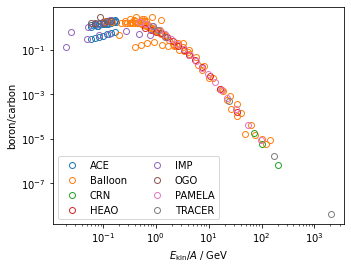

In [7]:
# let's plot the B/C ratios
import numpy as np
from matplotlib import pyplot as plt
import re
from collections import defaultdict

plt.figure()
plt.subplots_adjust(right=0.8)

# plot each experiment with different color, combine all sub-experiments
exps = defaultdict(lambda: False)
for this_sub_exp in tab["sub_exp"]:
    exp = re.match("([A-Za-z]+)", this_sub_exp).group(1)
    exps[exp] |= tab["sub_exp"] == this_sub_exp

for i, (exp, mask) in enumerate(exps.items()):
    ncycle = 8
    plt.plot(tab["e_mean"][mask], tab["value"][mask],
             "osD"[i // ncycle], 
             color="None", mec="C%i" % (i % ncycle),
             label=exp)

plt.legend(ncol=2)
plt.xlabel("$E_\\mathrm{kin} / A$ / GeV")
plt.ylabel("boron/carbon")
plt.loglog();

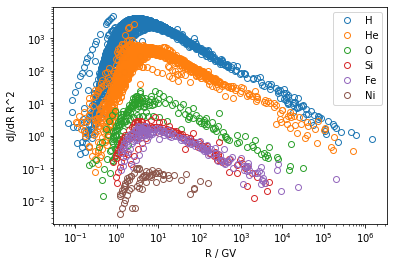

In [8]:
# plot fluxes of several elements vs rigidity scaled with R^2
for ielem, elem in enumerate(("H", "He", "O", "Si", "Fe", "Ni")):
    tab = crdb.query(elem, energy_type="R", flux_rescaling=2, energy_convert_level=2)
    plt.plot(tab["e_mean"], tab["value"], "o", color="None", mec=f"C{ielem}", label=elem)
plt.xlabel("R / GV")
plt.ylabel("dJ/dR R^2")
plt.legend()
plt.loglog();

## Caching queries

To speed up repeated queries and to reduce load on the CRDB server, you can cache the queries locally. There are several Python packages that do this kind of thing. Here we show [cachier](https://github.com/shaypal5/cachier).

You need to do `pip install cachier` for the following cell to work.

In [9]:
import cachier
import datetime

# crdb_query caches output of DB queries locally for 3 days
crdb_query = cachier.cachier(stale_after=datetime.timedelta(days=3))(crdb.query)

In [10]:
# Check how many proton datasets there are natively for each energy type.
# Note: this runs slow the first time.
for energy_type in ("R", "EKN", "EK", "ETOT"):
    d = crdb_query("H", energy_type=energy_type, energy_convert_level=0)
    print(energy_type, len(d))

R 202
EKN 4802
EK 0
ETOT 25


In [13]:
from IPython.display import Markdown

txt_parts = []

# Now check which experiment is using which energy type (this is now fast).
for energy_type in ("R", "EKN", "EK", "ETOT"):
    d = crdb_query("H", energy_type=energy_type, energy_convert_level=0)
    sub_exps = set()
    for x in np.unique(d["sub_exp"]):
        sub_exps.add(x)
    if not sub_exps:
        continue
    txt_parts.append("# " + energy_type + "\n" + " ".join(sorted(sub_exps)))

Markdown("\n".join(txt_parts))

# R
AMS02(2011/05-2013/11) Balloon(1961/07) Balloon(1962/07) Balloon(1963/01) Balloon(1963/04) Balloon(1963/06) Balloon(1963/11) Balloon(1970/09+1971/05) Explorer12(1961/08) IMP1(1963/11-1964/05) PAMELA(2006/07-2008/12)
# EKN
AMS01(1998/06) BESS-TeV(2002/08) BESS00(2000/08) BESS93(1993/07) BESS94(1994/07) BESS95(1995/07) BESS97(1997/07) BESS98(1998/07) BESS99(1999/08) Balloon(1955/07) Balloon(1956/03) Balloon(1956/08) Balloon(1956/09) Balloon(1959/05) Balloon(1959/06) Balloon(1960/08) Balloon(1960/09) Balloon(1961/08) Balloon(1963/07) Balloon(1964/06) Balloon(1964/07) Balloon(1964/09) Balloon(1965/06) Balloon(1965/06+1966/06) Balloon(1965/07) Balloon(1965/08) Balloon(1966/07)-1 Balloon(1966/07+1966/08) Balloon(1966/08) Balloon(1967/06)-2 Balloon(1967/07) Balloon(1968/06) Balloon(1968/07) Balloon(1969/06) Balloon(1969/07) Balloon(1970/06) Balloon(1970/07) Balloon(1970/11) Balloon(1971/07) Balloon(1972/07) Balloon(1976/05) Balloon(1977/07) Balloon(1979/06) Balloon(1987/05+1988/05+1989/05+1991/05) CAPRICE94(1994/08) CAPRICE98(1998/05) Discoverer36(1961/12) EPHIN(1995/01-1995/12) EPHIN(1996/01-1996/12) EPHIN(1997/01-1997/12) EPHIN(1998/01-1998/12) EPHIN(1999/01-1999/12) EPHIN(2000/01-2000/12) EPHIN(2001/01-2001/12) EPHIN(2002/01-2002/12) EPHIN(2003/01-2003/12) EPHIN(2004/01-2004/12) EPHIN(2005/01-2005/12) EPHIN(2006/01-2006/12) EPHIN(2007/01-2007/12) EPHIN(2008/01-2008/12) EPHIN(2009/01-2009/12) EPHIN(2010/01-2010/12) EPHIN(2011/01-2011/12) EPHIN(2012/01-2012/12) EPHIN(2013/01-2013/12) EPHIN(2014/01-2014/12) IMAX92(1992/07) IMP3(1965/05-1965/06) IMP3(1965/05-1965/09) IMP5(1970/04-1970/10) IMP5(1971/06-1971/09) IMP5(1972/06-1972/09) IMP7(1973/05-1973/07) IMP8(1974/07-1974/09) IMP8(1977/01-1979/12) JACEE(1979+1980+1982+1983+1984+1986+1987+1988+1990+1994+1995) LEAP(1987/08) MASS89(1989/09) MASS91(1991/09) MUBEE(1975/09+1978/08+1986/07+1987/07) PAMELA(2006/07-2006/07) PAMELA(2006/07-2006/08) PAMELA(2006/08-2006/09) PAMELA(2006/09-2006/10) PAMELA(2006/10-2006/11) PAMELA(2006/11-2006/12) PAMELA(2007/01-2007/02) PAMELA(2007/02-2007/03) PAMELA(2007/03-2007/03) PAMELA(2007/03-2007/04) PAMELA(2007/04-2007/05) PAMELA(2007/05-2007/06) PAMELA(2007/06-2007/07) PAMELA(2007/07-2007/08) PAMELA(2007/08-2007/09) PAMELA(2007/09-2007/10) PAMELA(2007/10-2007/11) PAMELA(2007/11-2007/11) PAMELA(2007/11-2007/12) PAMELA(2007/12-2008/01) PAMELA(2008/01-2008/02) PAMELA(2008/02-2008/03) PAMELA(2008/03-2008/04) PAMELA(2008/04-2008/05) PAMELA(2008/05-2008/06) PAMELA(2008/06-2008/07) PAMELA(2008/07-2008/08) PAMELA(2008/08-2008/08) PAMELA(2008/08-2008/09) PAMELA(2008/10-2008/10) PAMELA(2008/10-2008/11) PAMELA(2008/11-2008/12) PAMELA(2008/12-2009/01) PAMELA(2009/01-2009/02) PAMELA(2009/02-2009/03) PAMELA(2009/03-2009/04) PAMELA(2009/04-2009/05) PAMELA(2009/05-2009/05) PAMELA(2009/05-2009/06) PAMELA(2009/06-2009/07) PAMELA(2009/07-2009/08) PAMELA(2009/08-2009/09) PAMELA(2009/09-2009/10) PAMELA(2009/10-2009/11) PAMELA(2009/11-2009/12) PAMELA(2009/12-2010/01) PAMELA(2010/01-2010/01) PAMELA-CALO(2006/06-2010/01) Pioneer8(1968/04) RICH-II(1997/10) RUNJOB(1995+1996+1997+1998+1999) SOKOL(1984/03-1986/01) Ulysses-KET(1990/10-1991/02) Ulysses-KET(1992/07-1992/10) Ulysses-KET(1993/07-1993/10) Ulysses-KET(1994/07-1994/10) Voyager1(2008/05) Voyager1(2012/10-2012/12)
# ETOT
ATIC02(2003/01) CREAM-I(2004/12-2005/01)